<a href="https://colab.research.google.com/github/MahdiZaman/Spring2019-CAP5610/blob/master/ml_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

********Problem 1********

---



**Download The Data**

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-18 00:59:45--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   193MB/s    in 0.3s    

2019-04-18 00:59:45 (193 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

**Loading the convolutional base**

In [0]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

conv_base.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_____

**Freezing the Convolutional Base**

In [0]:
conv_base.trainable = False

**Concatenating the convolutional base and densely connected layers**

In [0]:
from keras import layers
from keras import models
from keras import optimizers
#
m = conv_base.output
m=layers.Flatten()(m)
m=layers.Dense(256, activation='relu')(m)
#
m = layers.Dense(1, activation='sigmoid')(m)
model = models.Model(inputs=[conv_base.input], outputs=[m])
#

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
for idx,layer in enumerate(model.layers):
  layer.trainable = idx >= 22 #Until 22, trainable is set to false

**Training the model end to end with frozen convolutional base**

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 23s 233ms/step - loss: 0.6236 - acc: 0.6580 - val_loss: 0.5079 - val_acc: 0.7840
Epoch 2/30
100/100 [==============================] - 18s 181ms/step - loss: 0.5279 - acc: 0.7505 - val_loss: 0.4303 - val_acc: 0.8090
Epoch 3/30
100/100 [==============================] - 19s 187ms/step - loss: 0.4832 - acc: 0.7830 - val_loss: 0.3788 - val_acc: 0.8280
Epoch 4/30
100/100 [==============================] - 17s 173ms/step - loss: 0.4521 - acc: 0.7995 - val_loss: 0.3530 - val_acc: 0.8460
Epoch 5/30
100/100 [==============================] - 17s 173ms/step - loss: 0.4403 - acc: 0.7955 - val_loss: 0.3368 - val_acc: 0.8550
Epoch 6/30
100/100 [==============================] - 17s 173ms/step - loss: 0.4089 - acc: 0.8140 - val_loss: 0.3243 - val_acc: 0.8580
Epoch 7/30
100/100 [==============================] - 18s 

**Displaying Accuracy and Loss in Training and Validation phase**

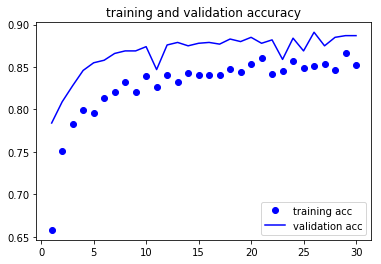

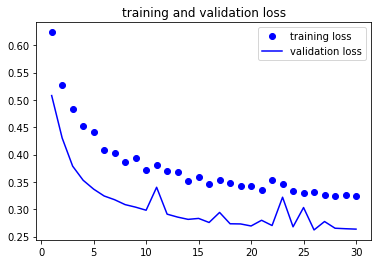

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

#
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)
#

Validation loss: 0.27486744172871114
Validation accuracy: 0.885999995470047


**Saving the model in Colab**

In [0]:
model_fname1 = 'catsdogsclassifier_p1.h5' 
model.save(model_fname1)
print("Model saved in Colab")

Model saved in Colab


In [0]:
from google.colab import files

with open(model_fname1, 'r') as f:
  files.download(model_fname)
print("Model_p1 downloaded on Local disk")
print("Problem 1 Ends")

Model downloaded on Local disk
Problem 1 Ends


### **Problem 2**

Loading model from Problem 1

In [0]:
from keras.models import load_model  
    
modelp2 = load_model(model_fname1)
modelp2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
for idx,layer in enumerate(modelp2.layers):
  layer.trainable = idx >= 20 #Setting the last Conv layer and the FC layers as trainable

In [0]:
modelp2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
# compile model

modelp2.compile(
  loss='binary_crossentropy', 
  optimizer=optimizers.RMSprop(lr=2e-5), 
  metrics=['acc'])

# train

history = modelp2.fit_generator(
  train_generator,
  steps_per_epoch=100,
  epochs=30,
  validation_data=validation_generator,
  validation_steps=30
)

val_loss, val_acc = modelp2.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Epoch 1/30
100/100 [==============================] - 18s 176ms/step - loss: 0.3122 - acc: 0.8695 - val_loss: 0.2467 - val_acc: 0.8933
Epoch 2/30
100/100 [==============================] - 16s 158ms/step - loss: 0.3248 - acc: 0.8655 - val_loss: 0.2839 - val_acc: 0.8800
Epoch 3/30
100/100 [==============================] - 17s 172ms/step - loss: 0.3154 - acc: 0.8655 - val_loss: 0.2650 - val_acc: 0.8883
Epoch 4/30
100/100 [==============================] - 16s 156ms/step - loss: 0.3255 - acc: 0.8610 - val_loss: 0.2768 - val_acc: 0.8767
Epoch 5/30
100/100 [==============================] - 16s 157ms/step - loss: 0.3038 - acc: 0.8680 - val_loss: 0.2724 - val_acc: 0.8900
Epoch 6/30
100/100 [==============================] - 18s 175ms/step - loss: 0.2952 - acc: 0.8790 - val_loss: 0.2652 - val_acc: 0.8883
Epoch 7/30
100/100 [==============================] - 16s 158ms/step - loss: 0.2959 - acc: 0.8755 - val_loss: 0.2432 - val_acc: 0.8817
Epoch 8/30
100/100 [==============================] - 1

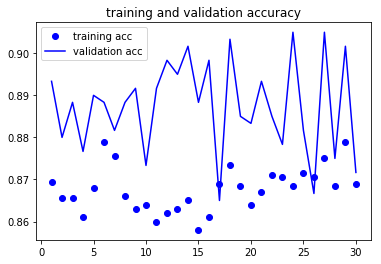

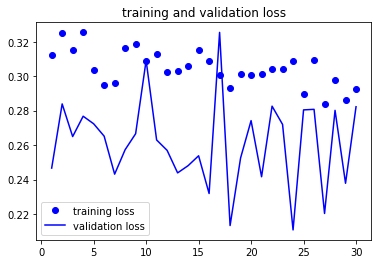

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [0]:
model_fname2 = 'catsdogsclassifier_p2.h5' 
modelp2.save(model_fname2)
print("Modelp2 saved in Colab")

Modelp2 saved in Colab


In [0]:
with open(model_fname2, 'r') as f:
  files.download(model_fname2)

In [0]:
modelp2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

# **Problem 3**

In [0]:
modelp3 = load_model('catsdogsclassifier_p2.h5')
modelp3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
modelp3 = load_model('catsdogsclassifier_p2.h5')
modelp3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
images, labels = next(validation_generator)

In [0]:
from keras import backend as K
import numpy as np
import cv2

last_conv_layer = modelp3.get_layer('block5_conv4')

def process_image(img):
    
    grads = K.gradients(modelp3.output[0], last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([modelp3.input], [pooled_grads, last_conv_layer.output[0], modelp3.output[0]])
    
    x = np.expand_dims(img, axis=0)
    pooled_grads_value, conv_layer_output_value, pred_value = iterate([x])
    
    if pred_value[0] < 1.0:
      if pred_value[0] < 0.5:
          conv_layer_output_value = 1-conv_layer_output_value 
      for i in range(512):
          conv_layer_output_value[:, :, i] *= (pooled_grads_value[i])

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    # normalize
    heatmap = (heatmap - heatmap.min())/(heatmap.max()-heatmap.min())
    
    heatmap_adj = cv2.resize(1-heatmap, (img.shape[1], img.shape[0]))
    heatmap_adj = np.uint8(255 * heatmap_adj)
    heatmap_adj = cv2.applyColorMap(heatmap_adj, cv2.COLORMAP_JET)
#     superimposed_img = show_superimposed_image(img, heatmap)
    
    superimposed_img = np.uint8(heatmap_adj * 0.4 + np.uint8(255 * img) * 0.6)
    
    return superimposed_img, pred_value[0], heatmap_adj
  

ValueError: ignored

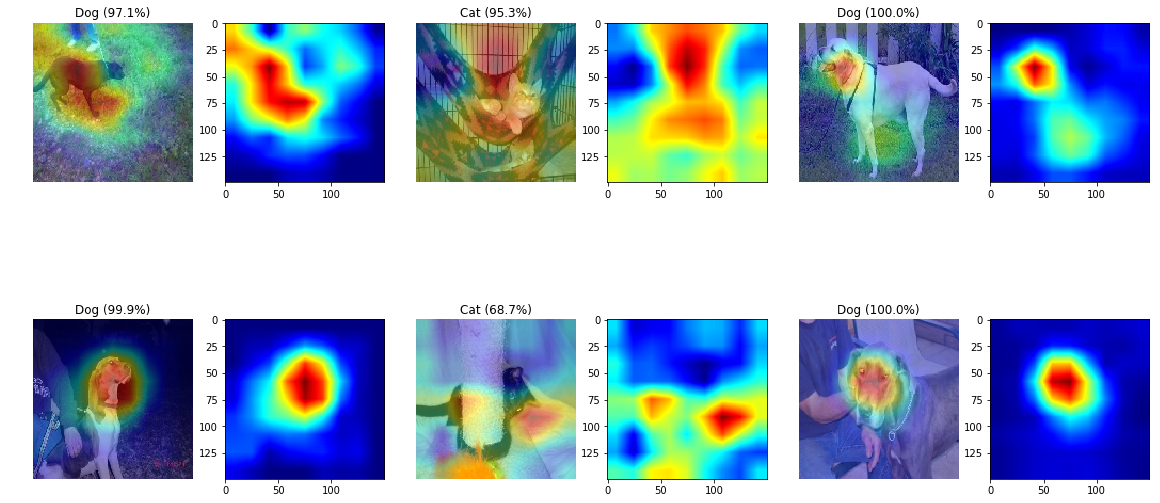

In [0]:
fig = plt.figure(figsize=(20, 10))
j=1
for i,img in enumerate(images[:10,]):
  superimposed_img, pred, heatmap = process_image(img)
  plt.subplot(2, 6, j)
  plt.imshow(superimposed_img)

  if pred < 0.5:
      class_name = "Cat"
      pred = 1-pred
  else:
    class_name = "Dog"

  plt.title("{} ({:.1f}%)".format(class_name, pred*100))
  plt.axis('off')

  plt.subplot(2, 6, j+1)
  plt.imshow(heatmap)

  j=j+2;
plt.show()

# Problem **4**

In [0]:
model4 = load_model('catsdogsclassifier_p2.h5')
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
layer = model4.get_layer('dense_3')
layer_output = layer.output

In [0]:
activation_model = models.Model(inputs=model4.input, outputs=[layer_output])

In [0]:
#Visualization of 1000 validation data

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=1000,
    class_mode='binary')
images, labels = next(validation_generator)

Found 1000 images belonging to 2 classes.
(1000, 150, 150, 3)
(1000,)


In [0]:
activations = activation_model.predict(images)
activations.shape

(1000, 256)

In [0]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns

In [0]:
def data_scatter(vecs, labels):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("husl", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('on')
    ax.axis('tight')


    for idx in range(num_classes):

        # Place label at median position of vectors with corresponding label

        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        txt = ax.text(x_coord, y_coord, class_names[idx], fontsize=16)
        # plot class index black with white contour
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=6, foreground="w"),
            PathEffects.Normal()])

In [0]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

catsvsdogs_tsne = TSNE(random_state=42).fit_transform(activations)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

t-SNE done! Time elapsed: 9.081488132476807 seconds


['Cat', 'Dog']


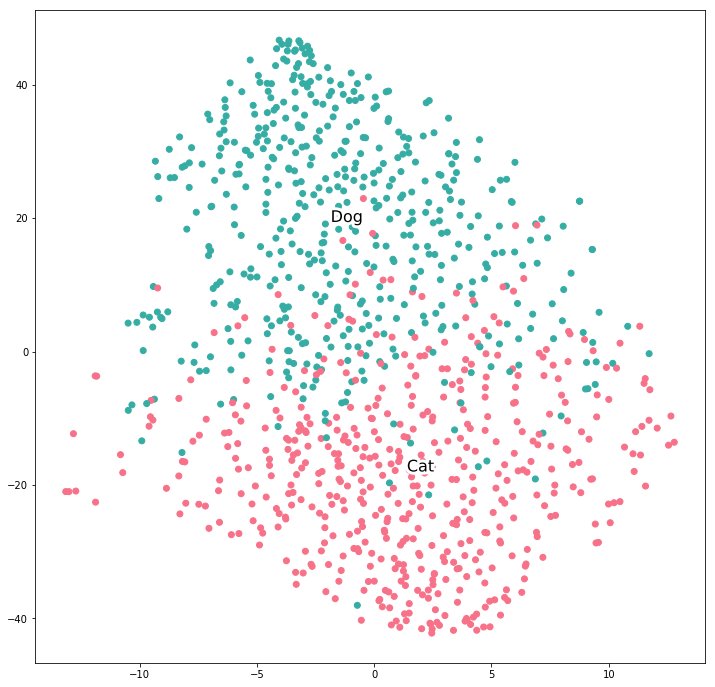

In [0]:
class_names = ["Cat", "Dog"]
print(class_names)

data_scatter(catsvsdogs_tsne, labels)